# Kuinka havaita petoksia vakuutushakemuksissa päätöksenpuumallien avulla 

In [1]:
#Tutkimusongelma

#Vakuutushakemukset ovat yksi petoksen välineistä.
#Kustannukset petoksista ovat suuret
#Manuaalinen selvitys viet aikaa ja on kallista.
#Tavoitteena on identifioida ja liputtaa petoksia vakuutushakemuksissa jo aikaisessa vaiheessa.

#Ladataan ensin data .txt file. Kaksiulotteinen frame sarakkeineen.

#kirjastojen tuonti
import pandas as pd #data frames (for storing data)
import numpy as np #scientific computing
import itertools

#matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick #for percentage ticks

#sklearn for modeling
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #Decision Tree algorithm
from sklearn.model_selection import train_test_split #Data split function
from sklearn.preprocessing import LabelEncoder #OneHotEncoding
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

#Decision tree plot
import pydotplus
from IPython.display import Image 

In [2]:
# Datan tuonti
data = pd.read_csv('insurance_fraud_data.txt') #ensure .ipynb notebook is in the same folder as the data set
data.head() #returns the first 5 rows; remove .head() to see the entire dataset

,claim_id,customer_id,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,32,Female,Driver error,225,Auto,No,Material only,2980.0,1,No
1,33985796,75740424,60,Female,Crime,11874,Home,Unknown,Material only,2980.0,3,No
2,53522022,30308357,27,Female,Other driver error,4,Auto,No,Material only,3369.5,1,Yes
3,13015401,47830476,39,Female,Natural causes,5278,Auto,No,Material only,1680.0,1,No
4,22890252,19269962,47,Male,Crime,2335,Auto,No,Material only,2680.0,1,No


In [3]:
# Exploratory data analysis (EDA), ymmärretään paremmin rakennetta, muuttujia ja arvoja. 
data.describe().round() #this command will provide basic statistics for all numeric variables

,claim_id,customer_id,age,days_to_incident,claim_amount,total_policy_claims
count,1100.0,1100.0,1100.0,1100.0,1100.0,1100.0
mean,48838190.0,50874698.0,48.0,2814.0,12318.0,2.0
std,29188060.0,28461020.0,18.0,2785.0,13688.0,1.0
min,26832.0,154557.0,18.0,2.0,1000.0,1.0
25%,23815805.0,26791756.0,33.0,636.0,1880.0,1.0
50%,48539331.0,49855152.0,47.0,2042.0,2750.0,1.0
75%,74074466.0,75949511.0,63.0,4154.0,23965.0,2.0
max,99775483.0,99961993.0,79.0,14991.0,48150.0,8.0


In [4]:
data.info() #this command will reveal missing values, NaN values and variable types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   claim_id             1100 non-null   int64  
 1   customer_id          1100 non-null   int64  
 2   age                  1100 non-null   int64  
 3   gender               1100 non-null   object 
 4   incident_cause       1100 non-null   object 
 5   days_to_incident     1100 non-null   int64  
 6   claim_area           1100 non-null   object 
 7   police_report        1100 non-null   object 
 8   claim_type           1100 non-null   object 
 9   claim_amount         1100 non-null   float64
 10  total_policy_claims  1100 non-null   int64  
 11  fraudulent           1100 non-null   object 
dtypes: float64(1), int64(5), object(6)
memory usage: 103.2+ KB


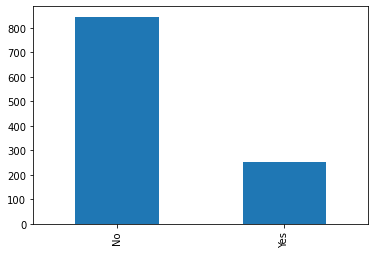

In [5]:
# Datan visualisaatio: petokset ja ei-petokset.
ax = data['fraudulent'].value_counts().plot(kind='bar')

#ax.set_xlabel('is fraud?')
#ax.set_ylabel('Count')

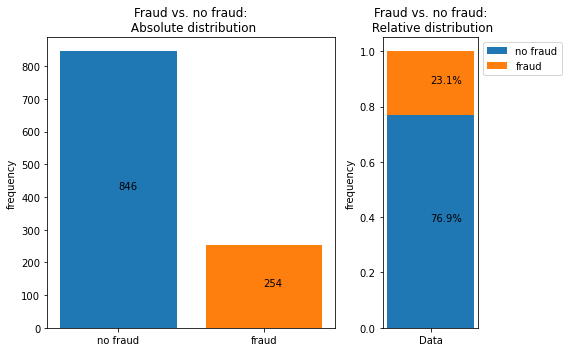

In [6]:
# plotataan petokset ja ei-petokset
# 77 % on petollisia tapauksia
keys, counts = np.unique(data.fraudulent, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1]) #specify relative size of left and right plot

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['no fraud', 'fraud'], counts, color=['#1f77b4','#ff7f0e']) #left bar plot
ax0 = plt.title('Fraud vs. no fraud:\n Absolute distribution') 
ax0 = plt.ylabel('frequency')
ax0 = plt.text(['no fraud'], counts[0]/2, counts[0]) #add text box with count of non-fraudulent cases
ax0 = plt.text(['fraud'], counts[1]/2, counts[1]) #add text box with count of fraudulent cases

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Data'], [counts_norm[0]], label='no fraud')
ax1 = plt.bar(['Data'], [counts_norm[1]], bottom=counts_norm[0], label='fraud')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Fraud vs. no fraud:\n Relative distribution')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Data'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Data'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.tight_layout()
plt.show()

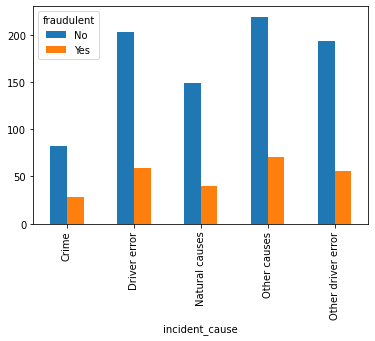

In [7]:
ax = data.groupby(['incident_cause', 'fraudulent'])['fraudulent'].count().unstack().plot.bar()

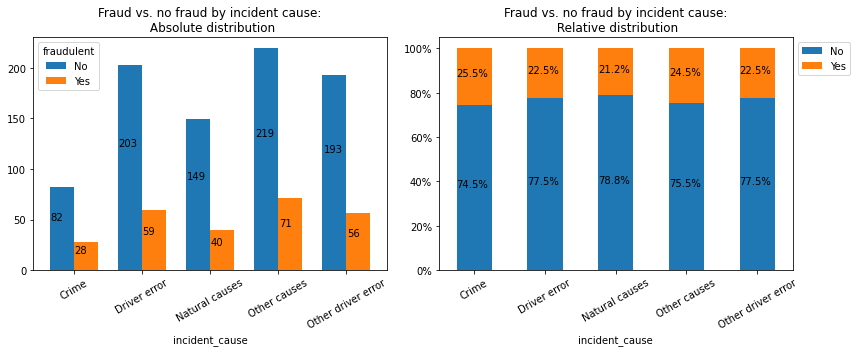

In [8]:
#frauds by incident cause
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['incident_cause', 'fraudulent'])['fraudulent'].count().unstack().plot.bar(rot=30, ax=plt.gca(), width=0.7)
plt.title('Fraud vs. no fraud by incident cause:\n Absolute distribution') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['incident_cause','fraudulent'])['fraudulent'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=30, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Fraud vs. no fraud by incident cause:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:5], ax2.patches[5:10]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

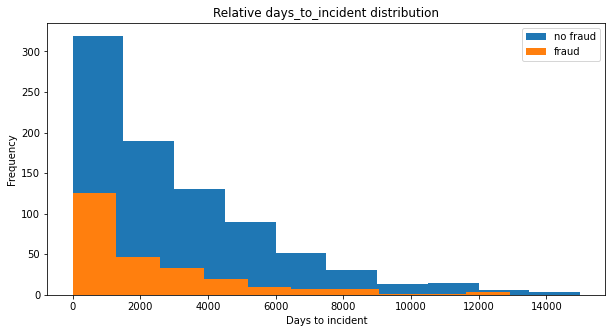

In [9]:
ax = data['days_to_incident'].loc[data['fraudulent'] == 'No'].plot.hist(bins=10, label='no fraud', figsize = (10,5))
ax = data['days_to_incident'].loc[data['fraudulent'] == 'Yes'].plot.hist(bins=10, label='fraud')
ax.set_xlabel('Days to incident')
ax.set_title('Relative days_to_incident distribution')
ax.legend();

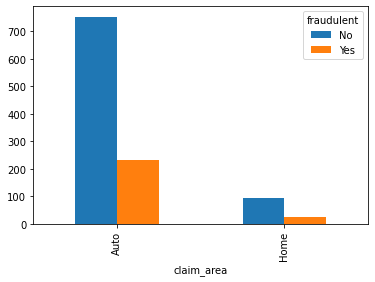

In [10]:
ax = data.groupby(['claim_area', 'fraudulent'])['fraudulent'].count().unstack().plot.bar()

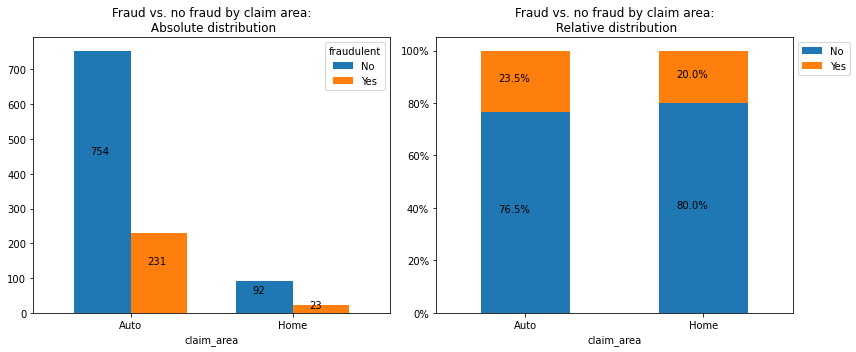

In [11]:
#frauds by claim area
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['claim_area', 'fraudulent'])['fraudulent'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Fraud vs. no fraud by claim area:\n Absolute distribution') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['claim_area','fraudulent'])['fraudulent'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Fraud vs. no fraud by claim area:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

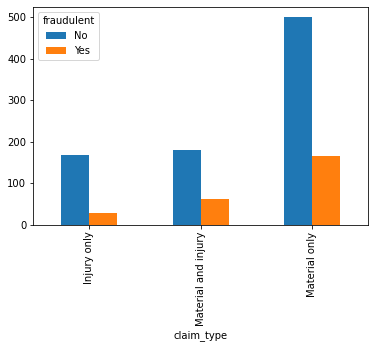

In [12]:
ax = data.groupby(['claim_type', 'fraudulent'])['fraudulent'].count().unstack().plot.bar()

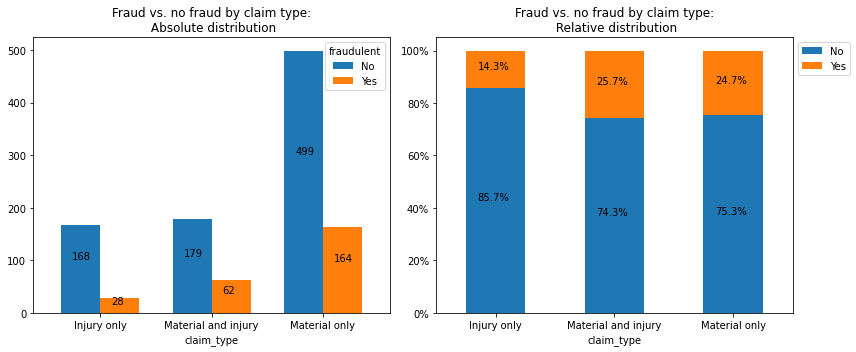

In [13]:
#frauds by claim area
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['claim_type', 'fraudulent'])['fraudulent'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Fraud vs. no fraud by claim type:\n Absolute distribution') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['claim_type','fraudulent'])['fraudulent'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Fraud vs. no fraud by claim type:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

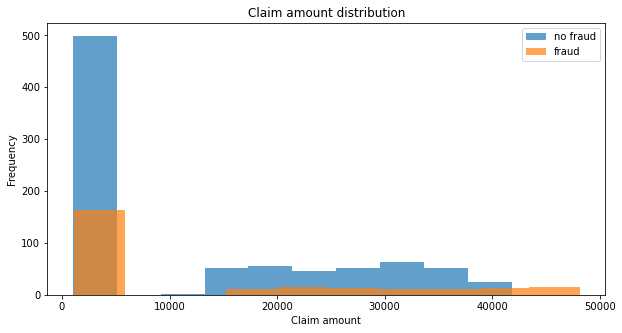

In [14]:
ax = data['claim_amount'].loc[data['fraudulent'] == 'No'].plot.hist(bins=10, alpha=0.7, label='no fraud', figsize = (10,5))
ax = data['claim_amount'].loc[data['fraudulent'] == 'Yes'].plot.hist(bins=10, alpha=0.7, label='fraud')
ax.set_xlabel('Claim amount')
ax.set_title('Claim amount distribution')
ax.legend();

In [15]:
# Datan esikäsittely
data.head()

,claim_id,customer_id,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,32,Female,Driver error,225,Auto,No,Material only,2980.0,1,No
1,33985796,75740424,60,Female,Crime,11874,Home,Unknown,Material only,2980.0,3,No
2,53522022,30308357,27,Female,Other driver error,4,Auto,No,Material only,3369.5,1,Yes
3,13015401,47830476,39,Female,Natural causes,5278,Auto,No,Material only,1680.0,1,No
4,22890252,19269962,47,Male,Crime,2335,Auto,No,Material only,2680.0,1,No


In [16]:
# Siirrä muuttujat pois mitkä eivät selitä mitään
data = data.drop(['claim_id', 'customer_id'], axis=1) #axis=1 drops a column (axis=0 drops a row)
data.head()

,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,32,Female,Driver error,225,Auto,No,Material only,2980.0,1,No
1,60,Female,Crime,11874,Home,Unknown,Material only,2980.0,3,No
2,27,Female,Other driver error,4,Auto,No,Material only,3369.5,1,Yes
3,39,Female,Natural causes,5278,Auto,No,Material only,1680.0,1,No
4,47,Male,Crime,2335,Auto,No,Material only,2680.0,1,No


In [17]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1100 non-null   int64  
 1   gender               1100 non-null   object 
 2   incident_cause       1100 non-null   object 
 3   days_to_incident     1100 non-null   int64  
 4   claim_area           1100 non-null   object 
 5   police_report        1100 non-null   object 
 6   claim_type           1100 non-null   object 
 7   claim_amount         1100 non-null   float64
 8   total_policy_claims  1100 non-null   int64  
 9   fraudulent           1100 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 86.1+ KB


In [18]:
# Uudelleenkoodaa kategoriset muuttujat
cleanup_nums = {"fraudulent": {"No": 0, "Yes": 1}}
data.replace(cleanup_nums, inplace=True)
data.head()

,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,32,Female,Driver error,225,Auto,No,Material only,2980.0,1,0
1,60,Female,Crime,11874,Home,Unknown,Material only,2980.0,3,0
2,27,Female,Other driver error,4,Auto,No,Material only,3369.5,1,1
3,39,Female,Natural causes,5278,Auto,No,Material only,1680.0,1,0
4,47,Male,Crime,2335,Auto,No,Material only,2680.0,1,0


In [19]:
data = pd.get_dummies(data, columns=["gender", "incident_cause", "claim_area", "police_report", "claim_type"], 
                      prefix=["gender", "cause", "area", "report", "type"]) #we add a prefix for easier identification

data.head().style

,age,days_to_incident,claim_amount,total_policy_claims,fraudulent,gender_Female,gender_Male,cause_Crime,cause_Driver error,cause_Natural causes,cause_Other causes,cause_Other driver error,area_Auto,area_Home,report_No,report_Unknown,report_Yes,type_Injury only,type_Material and injury,type_Material only
0,32,225,2980.000000,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
1,60,11874,2980.000000,3,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1
2,27,4,3369.500000,1,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1
3,39,5278,1680.000000,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1
4,47,2335,2680.000000,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1


In [20]:
# Datan splittaus 70:30  (data_train) ja (data_test) osuuteen.
X, y = data.loc[:, data.columns != 'fraudulent'], data['fraudulent'] #define feature matrix X and labels y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345) #split data 70:30

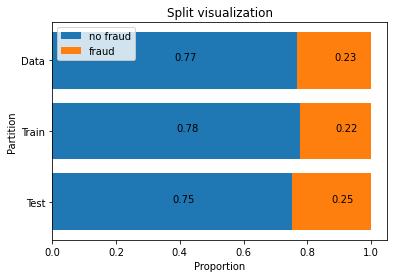

In [21]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = data['fraudulent'].value_counts() / len(data)

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='no fraud')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='fraud')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

In [22]:
# Mallintaminen
#Define Decision tree classifier with some default parameters
clf = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3)

#Fit the training data 
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=100)

In [23]:
#Use classifier to predict labels
y_pred = clf.predict(X_test)

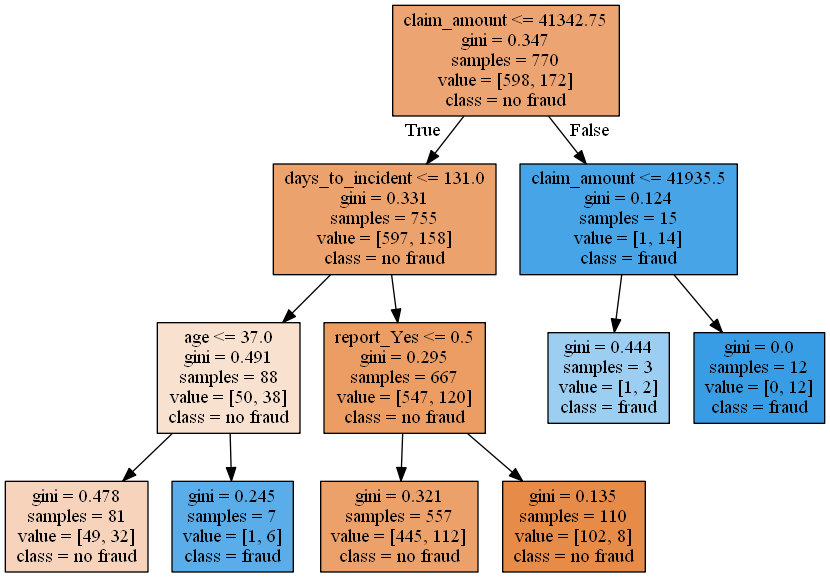

In [24]:
'''
The graphviz library is used to visualize the tree. 
'''

#Decision tree plot
import pydotplus
from IPython.display import Image 

# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['no fraud', 'fraud'], filled=True) #or use y_train.unique()

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

# Create PNG 
#graph.write_png("clf.png") #uncomment this line to save the plot as a .png file

In [25]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

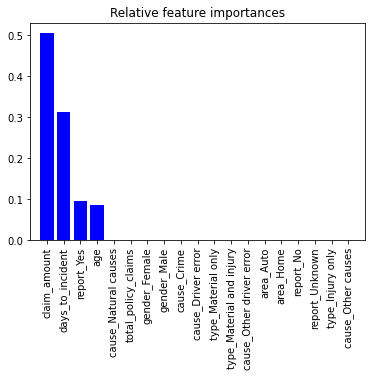

In [26]:
# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [27]:
# Mallin arviointi Classifier identifioi 76% hakemuksista.
print ("Accuracy is: ", (accuracy_score(y_test,y_pred)*100).round(2))

Accuracy is:  76.36


In [28]:
#print(classification_report(y_test, y_pred))  

In [29]:
# Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

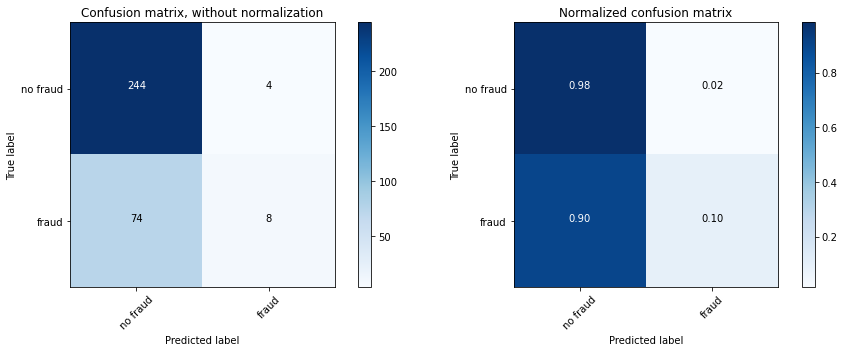

In [30]:
# Compute confusion matrix
class_names = ['no fraud', 'fraud']
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


plt.show()

In [31]:
# The Area Under the Curve (AUC) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("AUC score on Testing: " + str(roc_auc))

AUC score on Testing: 0.5407159716758458


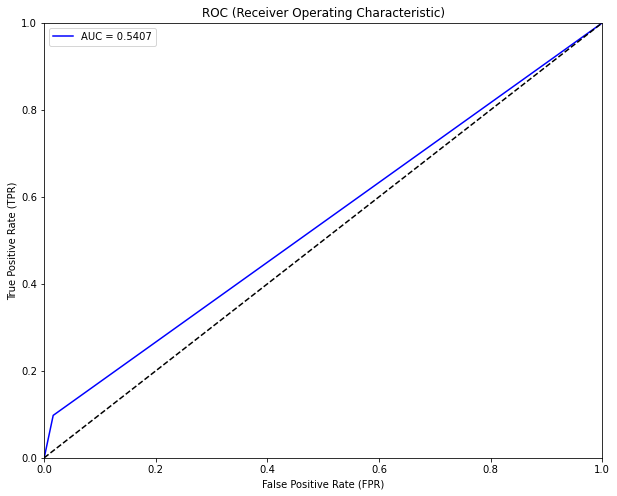

In [32]:
# ROC (Receiver Operating Characteristic)
fig, axs = plt.subplots(1,1, figsize=(10,8))

plt.title('ROC (Receiver Operating Characteristic)')
plt.plot(fpr, tpr, 'b', label='AUC = %0.4f'% roc_auc)
plt.legend(loc='best')
plt.plot([0,1],[0,1],color='black', linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)');

In [33]:
#Tulos
#Fraudulent claims without model: 942597
#Absolute savings: 318300
#Relative savings: 33.8%
#Savings potential: 581297
#Malli säästi vakuutusyhtiön kustannuksia $318,300, 33.8% alennus.

cost_manual_check = 500 #Manually checking a case flagged as fraud incurs labor costs
fraud_claims = 0 #Sum of all fraudulent claims
savings = 0 #How much the model saved (taking the labor cost into account)
savings_potential = 0 #How much the model could save if developed further 

for true, pred, claim in zip(y_test, y_pred, X_test.claim_amount):
    
    #Case 1: no fraud & model predicted no fraud -> nothing happens
    if true == 0 and pred == 0:
        ()
    
    #Case 2: no fraud, but model predicted fraud Incorrectly (false positive) -> we have to pay the manual check
    elif true == 0 and pred == 1:
        savings = savings - cost_manual_check
    
    #Case 3: fraud & model predicted fraud correctly -> pay check but also save the fraudulent claim
    elif true == 1 and pred == 1:
        savings = savings - cost_manual_check + claim
        fraud_claims = fraud_claims + claim
    
    #Case 4: fraud, but model missed it (false negative)
    elif true == 1 and pred == 0:
        savings_potential = savings_potential - cost_manual_check + claim
        fraud_claims = fraud_claims + claim

In [34]:
print ('Fraudulent claims without model: ' + str(int(fraud_claims)))
print ('Absolute savings: ' + str(int(savings)))
print ('Relative savings: ' + str(round(((savings/fraud_claims)*100),1)) + '%')
print ('Savings potential: ' + str(int(savings_potential)))

Fraudulent claims without model: 942597
Absolute savings: 318300
Relative savings: 33.8%
Savings potential: 581297
